In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os, sys
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from src.tt_eda.MPS_TN import MPS
from src.tt_eda.MPS_Opt import Opt_MPS
from experiments.stocks.stock_data import StockDataProcessor
from experiments.stocks.get_stock_data import download_stock_data
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 20,
    "legend.fontsize": 12,
    "axes.linewidth": 1.5,
})

/Users/admin/opt/anaconda3/envs/tenpy/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
q = 0.5
budget = 8
penalty = 1.2

processor = StockDataProcessor('all_stock_data.csv')
Q = processor.QUBO_from_Portfolio(
    B=q,
    q=penalty,
    t=budget
)
sigma = processor.get_covariance()

In [ ]:
from functools import partial
from experiments.stocks.models import markowitz_obj, equal_weighted_portf_volat_minim_obj

d_qubo = Q.shape[0] #same as the number of assets (dim of covariance matrix as well)
qubo_bbox_func = partial(markowitz_obj, Q_matrix=Q)
# qubo_bbox_func = partial(equal_weighted_portf_volat_minim_obj, sigma=Q, n_min=5, n_max=7)
phys_dim = 2
mps_rank = 3
mps_length = d_qubo # dimension of the QUBO matrix determines the length of the MPS 2^d_qubo scaling then, spin system stuff
M =1000
K = 20
k = 5
lr = 0.05
sweeps_gd = 10
base_seed = 1121231
rng_master = np.random.RandomState(base_seed)
seed = rng_master.randint(1, 1000000)

mps_init = MPS.uniform_pdf_MPS(
        length=mps_length,
        phys_leg_dim=phys_dim,
        const_chi=mps_rank
    )

qubo_optimizer = Opt_MPS(
    bbox_func=qubo_bbox_func,
    MPS_instance=mps_init,
    num_bbox_func_query=M,
    tot_num_samples=K,
    num_top_samples=k,
    learning_rate=lr,
    num_sweeps=sweeps_gd
)

print(f"Optimization with d={d_qubo} assets")
x_final_qubo, y_final_qubo, history_qubo = qubo_optimizer.opt_engine(base_seed=seed)
print(f"Best QUBO configuration x_min: {x_final_qubo}")
print(f"Best QUBO objective value y_min = x_min^T Q x_min: {y_final_qubo}")



Optimization with d=49 assets

--- Running Optimization ---
    Budget M=1000, K=20, k=5
    Update params: lr=0.05, sweeps=10, mut=0.0
    Iter 1 [Evals 20/1000]: Best y_min = 2.435e+03  LL = 3.075e+01
    Iter 5 [Evals 100/1000]: Best y_min = 1.446e+03  LL = 2.845e+01
    Iter 10 [Evals 200/1000]: Best y_min = 7.082e+02  LL = 1.927e+01
    Iter 15 [Evals 300/1000]: Best y_min = 1.525e+02  LL = 1.452e+01
    Iter 20 [Evals 400/1000]: Best y_min = 1.397e+01  LL = 7.272e+00
    Iter 25 [Evals 500/1000]: Best y_min = -1.063e+00  LL = 2.971e+00
    Iter 30 [Evals 600/1000]: Best y_min = -4.070e+00  LL = 2.720e-01
    Iter 35 [Evals 700/1000]: Best y_min = -4.070e+00  LL = 8.450e-02
    Iter 40 [Evals 800/1000]: Best y_min = -4.070e+00  LL = 7.261e-03
    Iter 45 [Evals 900/1000]: Best y_min = -4.070e+00  LL = 6.154e-04
    Iter 50 [Evals 1000/1000]: Best y_min = -4.070e+00  LL = 5.210e-05
--- Finished Optimization Engine (13.80 sec) ---
    Best value y_min: -4.070299298846037
    Best co

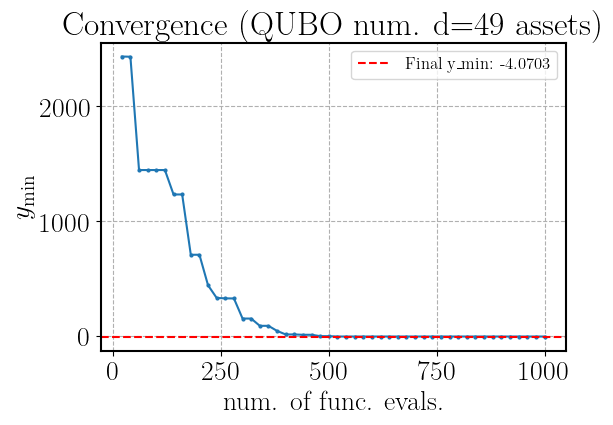

In [5]:
plt.figure(figsize=(6, 4))
evals = np.array([item[0] for item in history_qubo])
y_hist = np.array([item[1] for item in history_qubo])
finite_mask = np.isfinite(y_hist)
if np.any(finite_mask):
    plt.plot(evals[finite_mask], y_hist[finite_mask], marker='.', linestyle='-', markersize=4)
plt.xlabel('num. of func. evals.')
plt.ylabel(r'$y_{\mathrm{min}}$')
plt.title(f"Convergence (QUBO num. d={d_qubo} assets)")
plt.axhline(y=y_final_qubo, color='r', linestyle='--', label=f'Final y_min: {y_final_qubo:.4f}')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

In [6]:
from experiments.stocks.algos import sa_qubo

best_x, best_f, history = sa_qubo(markowitz_obj, Q, n_steps=1000, T0=5.0, alpha=0.9995, seed=seed)

print("Best objective value:", best_f)
print("Best configuration (first 20 bits):", best_x)
print("Number of selected assets:", best_x.sum())

Best objective value: -1.7988363474204805
Best configuration (first 20 bits): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
Number of selected assets: 1


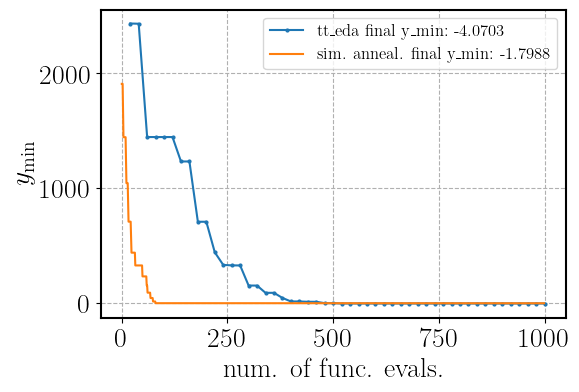

In [7]:
plt.figure(figsize=(6, 4))
evals = np.array([item[0] for item in history_qubo])
y_hist = np.array([item[1] for item in history_qubo])
finite_mask = np.isfinite(y_hist)
if np.any(finite_mask):
    plt.plot(evals[finite_mask], y_hist[finite_mask], marker='.', linestyle='-', markersize=4,label=f' tt_eda final y_min: {y_final_qubo:.4f}')
    plt.plot(history["best_f"],markersize=4,label=f' sim. anneal. final y_min: {best_f:.4f}')

plt.xlabel('num. of func. evals.')
plt.ylabel(r'$y_{\mathrm{min}}$')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()